# ES for ht for regression

HT to tune 
- lr 
- dropout 
- number of units 
- activation function 




## The NN

In [1]:
import time 
import pandas
import random
import json, argparse

# ML
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, roc_auc_score

# pytorch
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils

# software modules
import models_regression as Models
import utils
import dataset as Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print('Using device:', device)

In [2]:
dataset = pd.read_parquet('/home/samuele/Desktop/22_dl/DL_Project/stocks_forecasting_LOB/Data/LOBSTER/MSFT.parquet')
dataset = dataset.astype(float)
dataset = dataset.head(3000) # try all or 20k
#display(dataset)

In [3]:
#_, axs = plt.subplots(2, 2, figsize=(24,12))
#axs[0,0].plot(dataset['P_Ask_1'])
#axs[0,1].plot(dataset['V_Ask_1'])
#axs[1,0].plot(dataset['P_Bid_1'])
#axs[1,1].plot(dataset['V_Bid_1'])
#plt.show()

In [4]:
target_col = 'P_Ask_1'
target_cols = []
shifts = [ 1 ]

for shift in shifts:
    colname = f'Target_{shift}'
    target_cols.append(colname)
    dataset[colname] = dataset[target_col].shift(-shift)
dataset.dropna(inplace=True)

#display(dataset)

In [5]:
# Split the dataframe into train, validation and test
dataset_train, dataset_val, dataset_test = utils.DataTools.train_val_test_split(dataset)

# Standardize the data
#scaler = preprocessing.StandardScaler()
#scaler.fit(dataset_train)

#dataset_train[dataset_train.columns] = scaler.transform(dataset_train)
#dataset_val[dataset_val.columns] = scaler.transform(dataset_val)
#dataset_test[dataset_test.columns] = scaler.transform(dataset_test)

means = dataset_train.mean(axis=0)
stds = dataset_train.std(axis=0)

means[-len(target_cols):] = means[target_cols]
stds[-len(target_cols):] = stds[target_cols]

dataset_train = ( dataset_train - means ) / stds
dataset_val = ( dataset_val - means ) / stds
dataset_test = ( dataset_test - means ) / stds



#display(dataset_train)

In [6]:
# Split covariates and response variables
X_train, y_train = utils.DataTools.split_x_y(dataset_train, target_cols)
X_val, y_val = utils.DataTools.split_x_y(dataset_val, target_cols)
X_test, y_test = utils.DataTools.split_x_y(dataset_test, target_cols)

# Convert to pytorch tensors
X_train, X_val, X_test = utils.DataTools.numpy_to_tensor( X_train, X_val, X_test, dtype=torch.float32 )
y_train, y_val, y_test = utils.DataTools.numpy_to_tensor( y_train, y_val, y_test, dtype=torch.float32 )

# Create Torch Dataset
lookback_period = 100
dataset_train = Dataset.TimeSeriesDataset(
    X         = X_train,
    y         = y_train,
    seq_len_x = lookback_period,
    seq_len_y = 1,
    offset    = lookback_period-1,
    channels  = False,
    task      = Dataset.TimeSeriesDataset.Task.REGRESSION
)
dataset_val = Dataset.TimeSeriesDataset(
    X         = X_val,
    y         = y_val,
    seq_len_x = lookback_period,
    seq_len_y = 1,
    offset    = lookback_period-1,
    channels  = False,
    task      = Dataset.TimeSeriesDataset.Task.REGRESSION
)
dataset_test = Dataset.TimeSeriesDataset(
    X         = X_test,
    y         = y_test,
    seq_len_x = lookback_period,
    seq_len_y = 1,
    offset    = lookback_period-1,
    channels  = False,
    task      = Dataset.TimeSeriesDataset.Task.REGRESSION
)

# Create Torch DataLoader
batch_size = 32
dataloader_train = Dataset.TimeSeriesLoader(
    dataset = dataset_train,
    batch_size = batch_size,
    shuffle = True
)
dataloader_val = Dataset.TimeSeriesLoader(
    dataset = dataset_val,
    batch_size = batch_size,
    shuffle = False
)
dataloader_test = Dataset.TimeSeriesLoader(
    dataset = dataset_test,
    batch_size = batch_size,
    shuffle = False
)

print(f'Train dataset: {len(dataset_train)} samples')
print(f'Test dataset: {len(dataset_test)} samples')

Train dataset: 1900 samples
Test dataset: 252 samples


In [7]:
dataloader_train.dataset.channels = False
dataloader_val.dataset.channels = False
dataloader_test.dataset.channels = False

In [8]:
# Create the model
params = {
    'input_size': X_train.shape[1],
    'hidden_layer_size': 64,
    'num_layers': 2,
    'output_size': y_train.shape[1],
    'dropout': 0.2
}
model = Models.LSTM1(**params).to(device)

# Define loss function and optimizer
learning_rate = 1e-3
epochs = 5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
training_info = utils.ModelTools.train(
    model_id = 'LSTM1',
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    n_epochs = epochs,
    save = False,
    device = device
)

Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 0.8056619167327881, seconds
Epoch 1/5, Train Loss: 0.12264361, Val Loss:  0.03998199, 
[==========----------------------------------------] 20.0%  starting epoch 2
Duration of training epoch 2: 0.8575708866119385, seconds
Epoch 2/5, Train Loss: 0.02727260, Val Loss:  0.03137778, 
[====================------------------------------] 40.0%  starting epoch 3
Duration of training epoch 3: 0.7785418033599854, seconds
Epoch 3/5, Train Loss: 0.02379880, Val Loss:  0.02963189, 
[==============================--------------------] 60.0%  starting epoch 4
Duration of training epoch 4: 0.8181400299072266, seconds
Epoch 4/5, Train Loss: 0.02243410, Val Loss:  0.02817853, 
[========================================----------] 80.0%  starting epoch 5
Duration of training epoch 5: 0.9199349880218506, seconds
Epoch 5/5, Train Loss: 0.01907012, Val Loss:  0.03024920, 


In [9]:
print(
    np.mean(training_info['val_loss'][-5:])
    )

0.03188387728878297


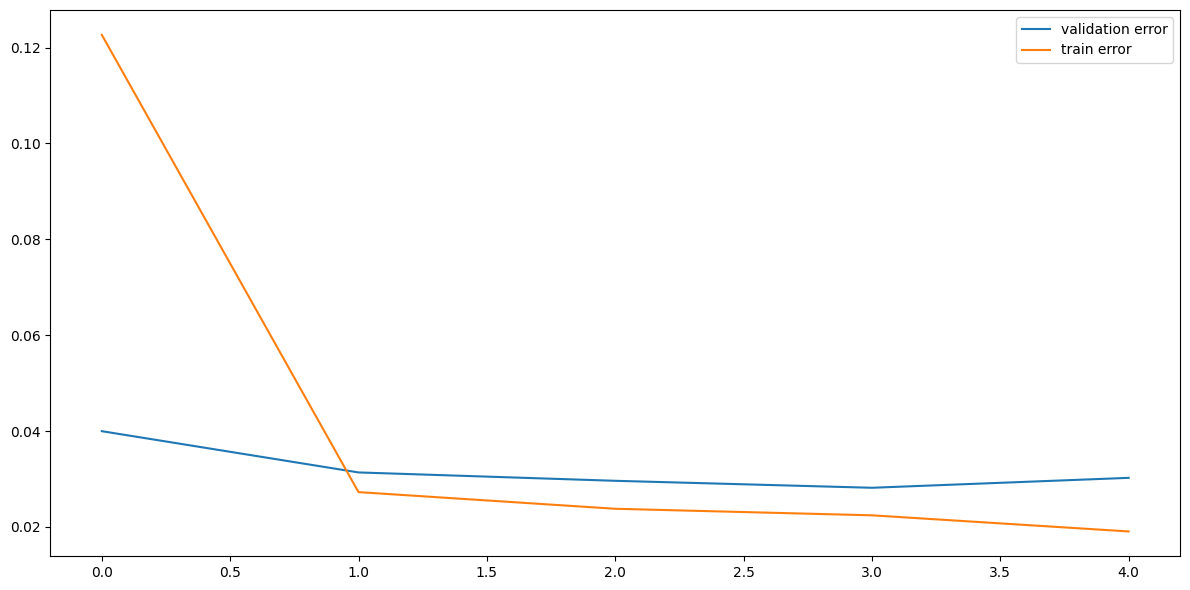

In [10]:
epochs_list = list(range(0,epochs))
plt.figure(figsize=(12,6))
plt.plot(epochs_list, training_info['val_loss'],  label = "validation error")
plt.plot(epochs_list, training_info['train_loss'], label = "train error")
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

## Useful commands 


In [11]:
# Useful libs

from tqdm.notebook import tqdm
import time as time
import sys # to stop the execution of the code
from IPython.display import display, Javascript # to save 
import pygame # to sound

# Display the progress bar

def display_progress_bar(estimated_time, num_updates):
    # Calculate the sleep interval between updates
    sleep_interval = estimated_time / num_updates

    # Display the progress bar
    with tqdm(total=num_updates) as pbar:
        for i in range(num_updates):
            time.sleep(sleep_interval)
            pbar.update(1)

estimated_time = 1
num_updates = 300

display_progress_bar(estimated_time, num_updates)

# Code before the exit

#print("This will run")
#raise SystemExit("Stopping execution here.")
#print("This will not run")


# Save the notebook

def save_notebook():
    display(Javascript('IPython.notebook.save_checkpoint();'))
print("This will be saved.")
save_notebook() # Save the notebook


# To play a sound

pygame.mixer.init() # Initialize the mixer module
#sound = pygame.mixer.Sound('./sound1.wav') # Load a sound file (ensure you have a .wav file)
#sound.play() # Play the sound
#pygame.time.wait(int(sound.get_length() * 1000)) # Ensure the sound has time to play



pygame 2.1.2 (SDL 2.0.20, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


  0%|          | 0/300 [00:00<?, ?it/s]

This will be saved.


<IPython.core.display.Javascript object>

## The EA 

### Structures

In [12]:
class Individual:
    def __init__(self, structure_gene, af_gene, lr_gene, dropout_gene ,fitness=0.0):
        """
        Initialize an individual with a gene, solution, and fitness.
        
        Parameters:
        gene (float): The value in the space of the gene.
        solution (Any): The value in the space of the solution.
        fitness (float): The fitness value of the individual.
        """
        self.structure_gene = structure_gene
        self.af_gene = af_gene
        self.lr_gene = lr_gene
        self.dropout_gene = dropout_gene

        self.structure_solution = self.from_structureGene_to_structureSolution(structure_gene)  
        self.af_solution = self.af_gene
        self.lr_solution = self.lr_gene
        self.dropout_solution = self.dropout_gene

        self.fitness = 0.0
    
    def from_structureGene_to_structureSolution(self, structureGenotype):
        """
        Convert the gene to a solution.
        """
        # For all element in the list of the genes, the solution is the list of the integer raund of the gene
        return [round(g) for g in structureGenotype]
    
    def __repr__(self):
        return f"Individual: nn_gene = {self.structure_gene}, af = {self.af_gene}, lr = {self.lr_gene}, dropout = {self.dropout_gene} | nn_sol = {self.structure_solution}, Fitness = {self.fitness}"

# Example usage:
ind = Individual([512, 512], nn.ReLU, 0.001, 0.2)
print(ind)

Individual: nn_gene = [512, 512], af = <class 'torch.nn.modules.activation.ReLU'>, lr = 0.001, dropout = 0.2 | nn_sol = [512, 512], Fitness = 0.0


### Initialization

In [13]:
def initialization(
        initial_population_size,
        number_of_layers_interval,
        number_of_units_interval,
        activation_functions,
        learning_rate_interval,
        dropout_interval):
    
    structure_genes = []
    
    for _ in range(initial_population_size):
        num_layers = random.randint(number_of_layers_interval[0], number_of_layers_interval[1])
        structure_gene = [random.randint(number_of_units_interval[0], number_of_units_interval[1]) for _ in range(num_layers)]
        structure_genes.append(structure_gene)

    af_genes = [random.choice(activation_functions) for _ in range(initial_population_size)]

    lr_genes = [random.uniform(learning_rate_interval[0], learning_rate_interval[1]) for _ in range(initial_population_size)]

    dropout_genes = [random.uniform(dropout_interval[0], dropout_interval[1]) for _ in range(initial_population_size)]
    
    individuals = [Individual(structure_gene, af_gene, lr_gene, dropout_gene) for structure_gene, af_gene, lr_gene, dropout_gene in zip(structure_genes, af_genes, lr_genes, dropout_genes)]

    return individuals

# Example usage
population_size = 5
number_of_layers_interval=[1, 5]
number_of_units_interval=[10, 600]
activation_functions=[nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU, nn.ELU, nn.SELU]
learning_rate_interval=[0.0001, 0.01]
dropout_interval=[0, 0.2]

population = initialization(
    initial_population_size = population_size,
    number_of_layers_interval = number_of_layers_interval,
    number_of_units_interval = number_of_units_interval,
    activation_functions = activation_functions,
    learning_rate_interval = learning_rate_interval,
    dropout_interval = dropout_interval)

print("Pop")
for individual in population:
    print(individual)

print("\nAn individual")
print(population[0].structure_gene)
print(population[0].lr_gene)
print(population[0].af_gene)
print(population[0].dropout_gene)

Pop
Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.0
Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.0
Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.0
Individual: nn_gene = [337, 412, 395, 37, 78], af = <class 'torch.nn.modules.activation.Sigmoid'>, lr = 0.005359429848240019, dropout = 0.03699075371346252 | nn_sol = [337, 412, 395, 37, 78], Fitness = 0.0
Individual: nn_gene = [294, 380, 183, 60, 322], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.005566250820094688, dropout = 0.12017907756079112 | nn_sol = [294, 380, 183, 60, 322], F

### Fitness assessment

UPDATE THIS FUNCTION

In [14]:
def fitness_evaluation(
        individual,
        training_data,
        validation_data,
        num_epochs_per_evaluation,
        #lr,
        input_size, # 40
        #hidden_sizes,
        output_size, # 15
        #activation_function,
        #initialize_weights,
        #dropout,
        device): 

    params = {
        'input_size': input_size,
        'hidden_layer_size': individual.structure_solution[0],
        'num_layers': 2,
        'output_size': output_size,
        'dropout': individual.dropout_solution,
    }
    model = Models.LSTM1(**params).to(device)

    # Optimizer parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=individual.lr_solution)
    criterion = nn.MSELoss()

    training_info = utils.ModelTools.train(
        model_id = 'LSTM1',
        model = model,
        criterion = criterion,
        optimizer = optimizer,
        train_loader = training_data,
        val_loader = validation_data,
        n_epochs = num_epochs_per_evaluation,
        save = False,
        device = device)

    return np.mean(training_info['val_loss'][-5:])
    


# Example usage:
individual = population[0]
training_data = dataloader_train
validation_data = dataloader_val
num_epochs_per_evaluation = 1
input_size = X_train.shape[1]
output_size = y_train.shape[1]
device = device

fitness = fitness_evaluation(
    individual = individual,
    training_data = training_data,
    validation_data = validation_data,
    num_epochs_per_evaluation = num_epochs_per_evaluation, # just for testing
    input_size = input_size,
    output_size = output_size,
    device = device)


Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 12.494683742523193, seconds
Epoch 1/1, Train Loss: 0.13502893, Val Loss:  0.02653606, 


In [15]:
# Assess population
def evaluate_individuals(
        individuals,
        training_data,
        validation_data,
        num_epochs_per_evaluation,
        #lr,
        input_size, # 40
        #hidden_sizes,
        output_size, # 15
        #activation_function,
        #initialize_weights,
        #dropout,
        device): 
    
    for individual in individuals:
        individual.fitness = fitness_evaluation(
            individual = individual,
            training_data = training_data,
            validation_data = validation_data,
            num_epochs_per_evaluation = num_epochs_per_evaluation,
            #lr,
            input_size = input_size, # 40
            #hidden_sizes,
            output_size = output_size, # 15
            #activation_function,
            #initialize_weights,
            #dropout,
            device = device)
        
    

# Example usage:
#population = population
training_data = dataloader_train    
validation_data = dataloader_val
num_epochs_per_evaluation = 1
input_size = X_train.shape[1]
output_size = y_train.shape[1]
device = device

evaluate_individuals(
    individuals = population,
    training_data = training_data,
    validation_data = validation_data,
    num_epochs_per_evaluation = num_epochs_per_evaluation,
    input_size = input_size,
    output_size = output_size,
    device = device)

print("Population:")
for individual in population:
    print(individual)

print("\nFitnesses:")
for individual in population:
    print(individual.fitness)

Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 11.482966423034668, seconds
Epoch 1/1, Train Loss: 0.13406188, Val Loss:  0.02857480, 
Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 20.152158498764038, seconds
Epoch 1/1, Train Loss: 0.18057390, Val Loss:  0.02535562, 
Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 25.160767316818237, seconds
Epoch 1/1, Train Loss: 0.06233638, Val Loss:  0.02356214, 
Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 9.622312068939209, seconds
Epoch 1/1, Train Loss: 0.18180497, Val Loss:  0.02613769, 
Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 7.570146799087524, seconds
E

### Selection

In [16]:
def find_best_individual(population, maximize):
    """
    Find the individual with the best fitness value in the population.
    
    Parameters:
    population (list): A list of Individual objects.
    
    Returns:
    Individual: The individual with the best fitness value.
    """
    if maximize:
        best_individual = max(population, key=lambda x: x.fitness)
    else:
        best_individual = min(population, key=lambda x: x.fitness)
    return best_individual

# Example usage:
#population: defined before
maximize = False

best_individual = find_best_individual(population = population, maximize = maximize)   
print(best_individual)

Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606


In [17]:
# Tournament selection
# number_of_selected: The number of individuals to be selected.
# percentage_of_population_size: The percentage of the population size to use for the tournament.
# heterogeneity = True: If True, the selected individuals must be unique.
def tournament_selection(population, number_of_selected, percentage_of_population_size, heterogeneity):
    selected_individuals = []
    tournament_size = max(1, int(len(population) * percentage_of_population_size))

    for _ in range(number_of_selected):
        if heterogeneity:
            # Ensure uniqueness
            best_individual = None
            while best_individual is None or best_individual in selected_individuals:
                # Randomly select individuals for the tournament
                tournament_individuals = random.sample(population, tournament_size)
                # Select the best individual from the tournament
                best_individual = min(tournament_individuals, key=lambda ind: ind.fitness)
        else:
            # Randomly select individuals for the tournament
            tournament_individuals = random.sample(population, tournament_size)
            # Select the best individual from the tournament
            best_individual = min(tournament_individuals, key=lambda ind: ind.fitness)

        selected_individuals.append(best_individual)

    return selected_individuals

# Example usage:
#population: defined before
number_of_selected = 4
percentage_of_population_size = 0.2 # 20% of the population size
heterogeneity = False

selected_individuals = tournament_selection(
    population = population,
    number_of_selected = number_of_selected,
    percentage_of_population_size = percentage_of_population_size,
    heterogeneity=heterogeneity)

print("\nPopulation:")
for individual in population:
    print(individual)

print("\nSelected individuals:")
for individual in selected_individuals:
    print(individual)


Population:
Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157
Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606
Individual: nn_gene = [337, 412, 395, 37, 78], af = <class 'torch.nn.modules.activation.Sigmoid'>, lr = 0.005359429848240019, dropout = 0.03699075371346252 | nn_sol = [337, 412, 395, 37, 78], Fitness = 0.02613769203890115
Individual: nn_gene = [294, 380, 183, 60, 322], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0055662508200

In [18]:
# Truncated selection
# k: The number of individuals to be selected.
# maximize: If True, select individuals with greatest fitness; otherwise, select individuals with smallest fitness.
def truncated_selection(population, k, maximize):
    # Sort the population based on fitness
    sorted_population = sorted(population, key=lambda ind: ind.fitness, reverse=maximize)
    
    # Select the top k individuals
    selected_individuals = sorted_population[:k]
    
    return selected_individuals

# Example usage:
# population: defined before
k = 4
maximize = False  # Change to True if you want to select individuals with greatest fitness

selected_individuals = truncated_selection(population = population, k = k, maximize = maximize)

print("\nPopulation:")
for individual in population:
    print(individual)

print("\nSelected individuals:")
for individual in selected_individuals:
    print(individual)


Population:
Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157
Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606
Individual: nn_gene = [337, 412, 395, 37, 78], af = <class 'torch.nn.modules.activation.Sigmoid'>, lr = 0.005359429848240019, dropout = 0.03699075371346252 | nn_sol = [337, 412, 395, 37, 78], Fitness = 0.02613769203890115
Individual: nn_gene = [294, 380, 183, 60, 322], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0055662508200

### Evolutionary operators 

#### Crossover operators

In [19]:
def correct_layer_size(gene, lb, ub):
    if gene < lb or gene > ub:
        if gene < lb:
            gene = lb
        else:
            gene = ub
    return gene
    
# Example of usage 
gene = 1000
lb = 16
ub = np.inf

corrected_gene = correct_layer_size(gene = gene, lb = lb, ub = ub)

print(f"Range: [{lb}, {ub}]")
print(f"\nGene: {gene}, \nCorrected gene: {corrected_gene}")


Range: [16, inf]

Gene: 1000, 
Corrected gene: 1000


In [20]:
def correct_layers_size(genotype, lb, ub):
    corrected_genotype = [lb if gene < lb else ub if gene > ub else gene for gene in genotype]
    return corrected_genotype

# Example of usage
genotype = [0, 20, 150]
lb = 10
ub = 100

corrected_genotype = correct_layers_size(genotype = genotype, lb = lb, ub = ub)

print(f"Range: [{lb}, {ub}]")
print(f"\nGenotype: {genotype}, \nCorrected genotype: {corrected_genotype}")

Range: [10, 100]

Genotype: [0, 20, 150], 
Corrected genotype: [10, 20, 100]


In [21]:
def correct_general_size(value, ub, lb):
    if value < lb:
        value = lb
    elif value > ub:
        value = ub
    return value

# Example of usage
value = 1
lb = 10
ub = 50

corrected_value = correct_general_size(value = value, ub = ub, lb = lb)

print(f"Range: [{lb}, {ub}]")
print(f"\nValue: {value}, \nCorrected value: {corrected_value}")

Range: [10, 50]

Value: 1, 
Corrected value: 10


In [22]:
# Description:
# aaa|aa 
# bbb|bb
# --> aaa|bb, bbb|aa
def structure_singlePointCX(parent1, parent2):
    gene1, gene2 = parent1.structure_gene, parent2.structure_gene
    af_gene1, af_gene2 = parent1.af_gene, parent2.af_gene
    lr_gene1, lr_gene2 = parent1.lr_gene, parent2.lr_gene
    if len(gene1) == 1 or len(gene2) == 1:
        return parent1, parent2  # No crossover if a parent has only one layer
    point = random.randint(1, min(len(gene1), len(gene2)) - 1)
    child_gene1 = gene1[:point] + gene2[point:]
    child_gene2 = gene2[:point] + gene1[point:]
    child1 = Individual(structure_gene=child_gene1, af_gene=af_gene1, lr_gene=lr_gene1, dropout_gene=parent1.dropout_gene)
    child2 = Individual(structure_gene=child_gene2, af_gene=af_gene2, lr_gene=lr_gene2, dropout_gene=parent2.dropout_gene)
    return child1, child2

# Exmaple usage
parent1 = population[0]
parent2 = population[2]
offspring1, offspring2 = structure_singlePointCX(parent1, parent2)

print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"\nOffspring2 CX: {offspring1}")
print(f"Offspring1 CX: {offspring2}")

Parent 1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Parent 2: Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606

Offspring2 CX: Individual: nn_gene = [377, 431], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 431], Fitness = 0.0
Offspring1 CX: Individual: nn_gene = [577, 127, 570, 19], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 127, 570, 19], Fitness = 0.0


In [23]:
def structure_SPC_E(parent1, parent2):
    gene1, gene2 = parent1.structure_gene, parent2.structure_gene
    af_gene1, af_gene2 = parent1.af_gene, parent2.af_gene
    lr_gene1, lr_gene2 = parent1.lr_gene, parent2.lr_gene
    
    # Determine the fittest parent
    if parent1.fitness < parent2.fitness:
        fitter_parent = parent1
        other_parent = parent2
    else:
        fitter_parent = parent2
        other_parent = parent1

    if len(gene1) == 1 or len(gene2) == 1:
        return parent1, parent2  # No crossover if a parent has only one layer
    
    point = random.randint(1, min(len(gene1), len(gene2)) - 1)
    
    # Split genes at the crossover point
    first_part_fitter = fitter_parent.structure_gene[:point]
    second_part_fitter = fitter_parent.structure_gene[point:]
    
    first_part_other = other_parent.structure_gene[:point]
    second_part_other = other_parent.structure_gene[point:]
    
    # Compute averages for the second part of genes
    avg_second_part = [(a + b) / 2 for a, b in zip(second_part_fitter, second_part_other)]
    avg_first_part = [(a + b) / 2 for a, b in zip(first_part_fitter, first_part_other)]
    
    # Create new genes for the children
    child_gene1 = first_part_fitter + avg_second_part
    child_gene2 = avg_first_part + second_part_fitter
    
    # Create child individuals
    child1 = Individual(structure_gene=child_gene1, af_gene=af_gene1, lr_gene =lr_gene1, dropout_gene=parent1.dropout_gene)
    child2 = Individual(structure_gene=child_gene2, af_gene=af_gene2, lr_gene =lr_gene2, dropout_gene=parent2.dropout_gene)
    
    return child1, child2

# Example usage
parent1 = population[0]
parent2 = population[2]
offspring1, offspring2 = structure_SPC_E(parent1, parent2)

print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"\nOffspring1: {offspring1}")
print(f"Offspring2: {offspring2}")

Parent 1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Parent 2: Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606

Offspring1: Individual: nn_gene = [577, 279.0], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [577, 279], Fitness = 0.0
Offspring2: Individual: nn_gene = [477.0, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [477, 431], Fitness = 0.0


In [24]:
# k = 0.5 is good, k = 0 is intermediate recombination 
def structure_SPC_lineRecombination(parent1, parent2, k, lb, ub):
    gene1, gene2 = parent1.structure_gene, parent2.structure_gene
    af_gene1, af_gene2 = parent1.af_gene, parent2.af_gene
    lr_gene1, lr_gene2 = parent1.lr_gene, parent2.lr_gene
    
    # Determine the fittest parent
    if parent1.fitness < parent2.fitness:
        fitter_parent = parent1
        other_parent = parent2
    else:
        fitter_parent = parent2
        other_parent = parent1

    if len(gene1) == 1 or len(gene2) == 1:
        return parent1, parent2  # No crossover if a parent has only one layer
    
    point = random.randint(1, min(len(gene1), len(gene2)) - 1)
    
    # Split genes at the crossover point
    first_part_fitter = fitter_parent.structure_gene[:point]
    second_part_fitter = fitter_parent.structure_gene[point:]
    
    first_part_other = other_parent.structure_gene[:point]
    second_part_other = other_parent.structure_gene[point:]
    
    # Compute averages for the second part of genes

    max_len_first_part = max(len(first_part_fitter), len(first_part_other))
    max_len_second_part = max(len(second_part_fitter), len(second_part_other))
    ks_first_part =  [random.uniform(-k, 1 + k) for _ in range(max_len_first_part)]
    ks_second_part =  [random.uniform(-k, 1 + k) for _ in range(max_len_second_part)]
    
    line_recombination_first_part = [
        kk * a + (1 - kk) * b
        for a, b, kk in zip(first_part_other, first_part_fitter, ks_first_part)]
    line_recombination_second_part = [
        kk * a + (1 - kk) * b
        for a, b, kk in zip(second_part_other, second_part_fitter, ks_second_part)]
    
    
    # Create new genes for the children
    child_gene1 = first_part_fitter + line_recombination_second_part
    child_gene2 = line_recombination_first_part + second_part_fitter

    child_gene1 = correct_layers_size(genotype=child_gene1, lb=lb, ub=ub)
    child_gene2 = correct_layers_size(genotype=child_gene2, lb=lb, ub=ub)
    
    # Create child individuals
    child1 = Individual(structure_gene=child_gene1, af_gene=af_gene1, lr_gene =lr_gene1, dropout_gene=parent1.dropout_gene)
    child2 = Individual(structure_gene=child_gene2, af_gene=af_gene2, lr_gene =lr_gene2, dropout_gene=parent2.dropout_gene)
    
    return child1, child2

# Example usage
parent1 = population[0]
parent2 = population[2]
k = 0
lb = 16
ub = np.inf
offspring1, offspring2 = structure_SPC_lineRecombination(parent1 = parent1, parent2 = parent2, k = k, lb = lb, ub = ub )


print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"\nOffspring1: {offspring1}")
print(f"Offspring2: {offspring2}")

Parent 1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Parent 2: Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606

Offspring1: Individual: nn_gene = [577, 256.1603071846655], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [577, 256], Fitness = 0.0
Offspring2: Individual: nn_gene = [404.2829335178634, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [404, 431], Fitness = 0.0


In [25]:
# k = 0.5 is good, k = 0 is intermediate recombination 
def structure_lineRecombination_oneLayer(parent1, parent2, k, lb, ub):
    gene1, gene2 = parent1.structure_gene[0], parent2.structure_gene[0]
        
    # Exctract two random point in (-k, 1+k)
    k1 = random.uniform(-k, 1 + k)
    k2 = random.uniform(-k, 1 + k)
    
    mutated_gene1 = k1 * gene1 + (1 - k1) * gene2
    mutated_gene2 = k2 * gene1 + (1 - k2) * gene2

    # Correct layer size 
    mutated_gene1 = correct_layer_size(gene = mutated_gene1, lb = lb, ub = ub)
    mutated_gene2 = correct_layer_size(gene = mutated_gene2, lb = lb, ub = ub)
    
    # Create child individuals
    child1 = Individual(structure_gene=[mutated_gene1], af_gene=parent1.af_gene, lr_gene =parent1.lr_gene, dropout_gene=parent1.dropout_gene)
    child2 = Individual(structure_gene=[mutated_gene2], af_gene=parent2.af_gene, lr_gene =parent2.lr_gene, dropout_gene=parent2.dropout_gene)
    
    return child1, child2

# Example usage
parent1 = population[0]
parent2 = population[2]
k = 0
lb = 16
ub = np.inf
offspring1, offspring2 = structure_lineRecombination_oneLayer(parent1 = parent1, parent2 = parent2, k = k, lb = lb, ub = ub )


print(f"Parent 1: {parent1.structure_gene[0]}")
print(f"Parent 2: {parent2.structure_gene[0]}")

print(f"\nOffspring1: {offspring1.structure_gene}")
print(f"Offspring2: {offspring2.structure_gene}")

Parent 1: 377
Parent 2: 577

Offspring1: [554.8414360715755]
Offspring2: [499.33229603159907]


In [26]:
def af_crossover(parent1, parent2, p_pick_the_best):

    # Find the af of the fittest parent
    if parent1.fitness < parent2.fitness:
        af1 = parent1.af_gene # af of the fittest parent
        af2 = parent2.af_gene
    else:
        af1 = parent2.af_gene
        af2 = parent1.af_gene

    # Define two individuals with a probability p to pick the af of the fittest parent
    if random.random() < p_pick_the_best:
        child1 = Individual(structure_gene=parent1.structure_gene, af_gene=af1, lr_gene=parent1.lr_gene, dropout_gene=parent1.dropout_gene)
        child2 = Individual(structure_gene=parent2.structure_gene, af_gene=af1, lr_gene=parent2.lr_gene, dropout_gene=parent2.dropout_gene)
    else:
        child1 = Individual(structure_gene=parent1.structure_gene, af_gene=af2, lr_gene=parent1.lr_gene, dropout_gene=parent1.dropout_gene)
        child2 = Individual(structure_gene=parent2.structure_gene, af_gene=af2, lr_gene=parent2.lr_gene, dropout_gene=parent2.dropout_gene)
    
    return child1, child2

# Example usage
parent1 = population[0]
parent2 = population[1]

p_pick_the_best = 0.5

offspring1, offspring2 = af_crossover(parent1, parent2, p_pick_the_best)

print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"\nOffspring1: {offspring1}")
print(f"Offspring2: {offspring2}")



Parent 1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Parent 2: Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157

Offspring1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.0
Offspring2: Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.0


In [27]:
def lr_linearRecombination(parent1, parent2, k, lb, ub):

    gene1 = parent1.lr_gene
    gene2 = parent2.lr_gene
    a1 = np.random.uniform(-k, 1 + k)
    a2 = np.random.uniform(-k, 1 + k)

    child_gene1 = a1 * gene1 + (1 - a1) * gene2
    child_gene2 = a2 * gene1 + (1 - a2) * gene2    

    # correct lr size 
    child_gene1 = correct_general_size(value = child_gene1, ub = ub, lb = lb)
    child_gene2 = correct_general_size(value = child_gene2, ub = ub, lb = lb)

    child1 = Individual(structure_gene=parent1.structure_gene, af_gene=parent1.af_gene, lr_gene=child_gene1, dropout_gene=parent1.dropout_gene)
    child2 = Individual(structure_gene=parent2.structure_gene, af_gene=parent2.af_gene, lr_gene=child_gene2, dropout_gene=parent2.dropout_gene)
                           
    return child1, child2

# Example usage:
parent1 = population[0]
parent2 = population[1]
k = 0
lb = 0.0001
ub = 0.1

offspring1, offspring2 = lr_linearRecombination(parent1, parent2, k, lb, ub)

print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"\nOffspring1: {offspring1}")
print(f"Offspring2: {offspring2}")


Parent 1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Parent 2: Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157

Offspring1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.0035941554680799614, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.0
Offspring2: Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.003578895639747029, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.0


In [28]:
def dropout_linearRecombination(parent1, parent2, k, lb, ub):

    gene1 = parent1.dropout_gene
    gene2 = parent2.dropout_gene
    a1 = np.random.uniform(-k, 1 + k)
    a2 = np.random.uniform(-k, 1 + k)

    child_gene1 = a1 * gene1 + (1 - a1) * gene2
    child_gene2 = a2 * gene1 + (1 - a2) * gene2    

    # correct lr size 
    child_gene1 = correct_general_size(value = child_gene1, ub = ub, lb = lb)
    child_gene2 = correct_general_size(value = child_gene2, ub = ub, lb = lb)

    child1 = Individual(structure_gene=parent1.structure_gene, af_gene=parent1.af_gene, lr_gene=parent1.lr_gene, dropout_gene=child_gene1)
    child2 = Individual(structure_gene=parent2.structure_gene, af_gene=parent2.af_gene, lr_gene=parent2.lr_gene, dropout_gene=child_gene2)
                           
    return child1, child2

# Example usage:
parent1 = population[0]
parent2 = population[1]
k = 0
lb = 0.0
ub = 0.2

offspring1, offspring2 = dropout_linearRecombination(parent1, parent2, k, lb, ub)

print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"\nOffspring1: {offspring1}")
print(f"Offspring2: {offspring2}")


Parent 1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Parent 2: Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157

Offspring1: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.13739865750603286 | nn_sol = [377, 127, 570, 19], Fitness = 0.0
Offspring2: Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.1142030135371404 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.0


#### Mutation operators

In [29]:
def structure_PP_selfAdaptiveMutation(population):
    # Find the maximum lenght of the genes of the population 
    max_len = max([len(ind.structure_gene) for ind in population])

    # Find the mean of each gene of the genotype
    genotype_mean = [np.mean([ind.structure_gene[i] for ind in population if i < len(ind.structure_gene)]) for i in range(max_len)]

    # Find the maximum of each gene of the genotype
    genotype_max = [np.max([ind.structure_gene[i] for ind in population if i < len(ind.structure_gene)]) for i in range(max_len)]

    return genotype_mean, genotype_max

# Example usage
#population: defined before
genotype_mean, genotype_max = structure_PP_selfAdaptiveMutation(population)

print("Population:")
for individual in population:
    print(individual)

print("\nGenotype mean:")
print(genotype_mean)    

print("\nGenotype max:")
print(genotype_max)    


Population:
Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157
Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606
Individual: nn_gene = [337, 412, 395, 37, 78], af = <class 'torch.nn.modules.activation.Sigmoid'>, lr = 0.005359429848240019, dropout = 0.03699075371346252 | nn_sol = [337, 412, 395, 37, 78], Fitness = 0.02613769203890115
Individual: nn_gene = [294, 380, 183, 60, 322], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.00556625082009

In [30]:
def structure_selfAdaptiveGaussianMutation(parent, genotype_mean, lb, ub):
    gene = parent.structure_gene
    mutated_gene = []
    for i in range(len(gene)):
        mutated_gene.append(gene[i] + np.random.normal(0, genotype_mean[i]/10))
        mutated_gene[i] = correct_layer_size(gene=mutated_gene[i], lb=lb, ub=ub)
    return Individual(structure_gene=mutated_gene, af_gene=parent.af_gene, lr_gene=parent.lr_gene, dropout_gene=parent.dropout_gene)  
    
# Example usage
parent = population[0]
#genotype_mean: defined before
lb = 16
ub = np.inf

mutated_individual = structure_selfAdaptiveGaussianMutation(parent=parent, genotype_mean=genotype_mean, lb=lb, ub=ub)

print(f"Gentype mean: {genotype_mean}\n")

for g1, g2 in zip(parent.structure_gene, mutated_individual.structure_gene):
    print(f"Gene: {g1} -> {g2}")


Gentype mean: [420.8, 351.0, 397.25, 171.75, 167.33333333333334]

Gene: 377 -> 364.1901375281292
Gene: 127 -> 116.46529701693716
Gene: 570 -> 595.8368140062012
Gene: 19 -> 25.876282420635082


In [31]:
def af_mutation(parent, activation_functions, p_change_af):
    gene = parent.af_gene
    if random.random() < p_change_af:
        gene = random.choice(activation_functions)
    return Individual(structure_gene=parent.structure_gene, af_gene=gene, lr_gene=parent.lr_gene, dropout_gene=parent.dropout_gene)

# Example usage
parent = population[0]
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU, nn.ELU, nn.SELU]
p_change_af = 0.5

mutated_individual = af_mutation(parent=parent, activation_functions=activation_functions, p_change_af=p_change_af)

print(f"Parent: {parent}")
print(f"Mutated individual: {mutated_individual}")

Parent: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Mutated individual: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.ELU'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.0


In [32]:
def lr_PP_selfAdaptiveMutation(population):
    # Find the mean of the learning rates of the population
    lr_mean = np.mean([ind.lr_gene for ind in population])
    return lr_mean

# Example usage
#population: defined before

lr_mean = lr_PP_selfAdaptiveMutation(population)

print("Population:")
for individual in population:
    print(individual)

print(f"\nLearning rate mean: {lr_mean}")


Population:
Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157
Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606
Individual: nn_gene = [337, 412, 395, 37, 78], af = <class 'torch.nn.modules.activation.Sigmoid'>, lr = 0.005359429848240019, dropout = 0.03699075371346252 | nn_sol = [337, 412, 395, 37, 78], Fitness = 0.02613769203890115
Individual: nn_gene = [294, 380, 183, 60, 322], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.00556625082009

In [33]:
def dropout_PP_selfAdaptiveMutation(population):
    # Find the mean of the learning rates of the population
    dropout_mean = np.mean([ind.dropout_gene for ind in population])
    return dropout_mean

# Example usage
#population: defined before

dropout_mean = dropout_PP_selfAdaptiveMutation(population)

print("Population:")
for individual in population:
    print(individual.dropout_gene)

print(f"\nLearning rate mean: {dropout_mean}")


Population:
0.14571091681565093
0.011325486426682697
0.004836673466477404
0.03699075371346252
0.12017907756079112

Learning rate mean: 0.06380858159661293


In [34]:
def lr_selfAdaptiveGaussianMutation(parent, lr_mean, lb, ub):
    gene = parent.lr_gene
    mutated_gene = gene + np.random.normal(0, lr_mean/10)
    mutated_gene = correct_general_size(value=mutated_gene, lb=lb, ub=ub)
    return Individual(structure_gene=parent.structure_gene, af_gene=parent.af_gene, lr_gene=mutated_gene, dropout_gene=parent.dropout_gene)

# Example usage
parent = population[0]
#lr_mean: defined before
lb = 0.0001
ub = 0.01

mutated_individual = lr_selfAdaptiveGaussianMutation(parent=parent, lr_mean=lr_mean, lb=lb, ub=ub)

print(f"Parent: {parent.lr_gene}")
print(f"lr mean: {lr_mean}")

print(f"\nMutated individual: {mutated_individual.lr_gene}")


Parent: 0.004069676109614568
lr mean: 0.0038970885617401604

Mutated individual: 0.0035660029175216216


In [35]:
def dropout_selfAdaptiveGaussianMutation(parent, dropout_mean, lb, ub):
    gene = parent.dropout_gene
    mutated_gene = gene + np.random.normal(0, dropout_mean/10)
    mutated_gene = correct_general_size(value=mutated_gene, lb=lb, ub=ub)
    return Individual(structure_gene=parent.structure_gene, af_gene=parent.af_gene, lr_gene=parent.lr_gene, dropout_gene=mutated_gene)

# Example usage
parent = population[0]
#dropout_mean: defined before
lb = 0.0
ub = 0.2

mutated_individual = dropout_selfAdaptiveGaussianMutation(parent=parent, dropout_mean=dropout_mean, lb=lb, ub=ub)

print(f"Parent: {parent.dropout_gene}")
print(f"lr mean: {dropout_mean}")

print(f"\nMutated individual: {mutated_individual.dropout_gene}")


Parent: 0.14571091681565093
lr mean: 0.06380858159661293

Mutated individual: 0.1449278152385735


In [36]:
# This mutation removes a gene
def structure_shrink_mutation(individual):
    mutated_gene = individual.structure_gene.copy()
    if len(mutated_gene) <= 1:
        return Individual(structure_gene=mutated_gene, af_gene=individual.af_gene, lr_gene=individual.lr_gene, dropout_gene=individual.dropout_gene)
    
    index = random.randint(0, len(mutated_gene) - 1)
    mutated_gene.pop(index)
    
    return Individual(structure_gene=mutated_gene, af_gene=individual.af_gene, lr_gene=individual.lr_gene, dropout_gene=individual.dropout_gene)  

# Example usage
individual = population[0]
mutated_individual = structure_shrink_mutation(individual)

print(f"Individual: {individual}")
print(f"Mutated individual: {mutated_individual}")

Individual: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Mutated individual: Individual: nn_gene = [377, 127, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 19], Fitness = 0.0


In [37]:
# This mutation adds a gene
def structure_gaussianGrowMutation(individual, genotype_mean, position, lb, ub):
    mutated_gene = individual.structure_gene.copy()
    
    # Determine the index to insert the new gene 
    if position == 'beginning':
        index = 0
    elif position == 'end':
        index = len(mutated_gene)
    else:  # Default to inserting at a random position
        index = random.randint(0, len(mutated_gene))

    # If condition 
    # It can happen that the new layer is the last one AND the largest individual has less number of layer 
    # So, we don't have data on the average of the population for that position  
    if index == len(mutated_gene) and len(mutated_gene) >= len(genotype_mean):
        inspiration_index = random.randint(0, len(genotype_mean) - 1) # Randomly select an index from the genotype
        new_layer_size = np.random.normal(genotype_mean[inspiration_index], genotype_mean[inspiration_index]/10)
        new_layer_size = correct_layer_size(gene=new_layer_size, lb=lb, ub=ub)
        mutated_gene.insert(index, new_layer_size)
    else:
        new_layer_size = np.random.normal(genotype_mean[index], genotype_mean[index]/10)
        new_layer_size = correct_layer_size(gene=new_layer_size, lb=lb, ub=ub)
        mutated_gene.insert(index, new_layer_size)
    
    return Individual(structure_gene=mutated_gene, af_gene=individual.af_gene, lr_gene=individual.lr_gene, dropout_gene=individual.dropout_gene)

# Example usage
individual = population[0]
#genotype_max: defined before
#genotype_mean: defined before
position = 'random'
lb = 16
ub = np.inf

mutated_individual = structure_gaussianGrowMutation(individual=individual, genotype_mean=genotype_mean, position=position, lb=lb, ub=ub)

print(f"Genotype mean: {genotype_mean}\n")

print(f"Individual: {individual}")
print(f"Mutated individual: {mutated_individual}")



Genotype mean: [420.8, 351.0, 397.25, 171.75, 167.33333333333334]

Individual: Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Mutated individual: Individual: nn_gene = [479.5525087625506, 377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [480, 377, 127, 570, 19], Fitness = 0.0


### Update population

In [38]:
def generate_offsprings(
        population,
        number_of_offsprings,
        tournament_percentage,
        p_crossover_vs_mutation,
        structure_k_crossover,
        structure_lb_size,
        structure_ub_size,
        #af_p_pick_the_best,
        lr_k,
        dropout_k,
        #p_changeLength_mutation,
        #structure_grow_position,
        #activation_functions,
        #af_p_change_af,
        lr_lb,
        lr_ub,
        dropout_lb,
        dropout_ub):
    
    offsprings = []

    # Pre-process the population
    structure_genotype_mean, _ = structure_PP_selfAdaptiveMutation(population=population)
    lr_genotype_mean = lr_PP_selfAdaptiveMutation(population=population)
    dropout_genotype_mean = dropout_PP_selfAdaptiveMutation(population=population)

    for _ in range(number_of_offsprings // 2):
        # Select parents for crossover
        parent1, parent2 = tournament_selection(population = population, number_of_selected=2, percentage_of_population_size=tournament_percentage, heterogeneity=True)

        if random.random() < p_crossover_vs_mutation:
            offspring1, offspring2 = structure_lineRecombination_oneLayer(parent1=parent1, parent2=parent2, k=structure_k_crossover, lb=structure_lb_size, ub=structure_ub_size)
            offspring1, offspring2 = lr_linearRecombination(parent1=offspring1, parent2=offspring2, k = lr_k, lb = lr_lb, ub =lr_ub)
            offspring1, offspring2 = dropout_linearRecombination(parent1=offspring1, parent2=offspring2, k = dropout_k, lb = dropout_lb, ub =dropout_ub)
        else:
            offspring1 = structure_selfAdaptiveGaussianMutation(parent = parent1, genotype_mean=structure_genotype_mean, lb = structure_lb_size, ub = structure_ub_size)
            offspring2 = structure_selfAdaptiveGaussianMutation(parent = parent2, genotype_mean=structure_genotype_mean, lb = structure_lb_size, ub = structure_ub_size)

            offspring1 = lr_selfAdaptiveGaussianMutation(parent = offspring1, lr_mean = lr_genotype_mean, lb = lr_lb, ub =lr_ub)
            offspring2 = lr_selfAdaptiveGaussianMutation(parent = offspring2, lr_mean = lr_genotype_mean, lb = lr_lb, ub =lr_ub)

            offspring1 = dropout_selfAdaptiveGaussianMutation(parent = offspring1, dropout_mean = dropout_genotype_mean, lb = dropout_lb, ub =dropout_ub)
            offspring2 = dropout_selfAdaptiveGaussianMutation(parent = offspring2, dropout_mean = dropout_genotype_mean, lb = dropout_lb, ub =dropout_ub)

        # Add the offspring to the population
        offsprings.append(offspring1)
        offsprings.append(offspring2)
            
    # If it is odd
    if number_of_offsprings % 2 == 1:
        parent = tournament_selection(population = population, number_of_selected = 1, percentage_of_population_size = tournament_percentage, heterogeneity=False)[0]
        offspring = structure_selfAdaptiveGaussianMutation(parent = parent, genotype_mean = structure_genotype_mean, lb = structure_lb_size, ub = structure_ub_size)
        offspring = lr_selfAdaptiveGaussianMutation(parent = offspring, lr_mean = lr_genotype_mean, lb = lr_lb, ub =lr_ub)
        offspring = dropout_selfAdaptiveGaussianMutation(parent = offspring, dropout_mean = dropout_genotype_mean, lb = dropout_lb, ub =dropout_ub)
        offsprings.append(offspring)    

    return offsprings



# Example usage
#population: defined before
number_of_offsprings = 4
tournament_percentage = 0.2
p_crossover_vs_mutation = 0.5
structure_k_crossover = 0
structure_lb_size = 16
structure_ub_size = np.inf
lr_k = 0
dropout_k = 0
lr_lb = 0.0001
lr_ub = 0.1
dropout_lb = 0.0
dropout_ub = 0.2

offsprings = generate_offsprings(
    population = population,
    number_of_offsprings = number_of_offsprings,
    tournament_percentage = tournament_percentage,
    p_crossover_vs_mutation = p_crossover_vs_mutation,
    structure_k_crossover = structure_k_crossover,
    structure_lb_size = structure_lb_size,
    structure_ub_size = structure_ub_size,
    lr_k = lr_k,
    dropout_k = dropout_k,
    lr_lb = lr_lb,
    lr_ub = lr_ub,
    dropout_lb = dropout_lb,
    dropout_ub = dropout_ub)

print("\nPopulation:")
for individual in population:
    print(individual)

print("\nOffsprings:")
for offspring in offsprings:
    print(offspring)
    
    


Population:
Individual: nn_gene = [377, 127, 570, 19], af = <class 'torch.nn.modules.activation.Tanh'>, lr = 0.004069676109614568, dropout = 0.14571091681565093 | nn_sol = [377, 127, 570, 19], Fitness = 0.02857479895465076
Individual: nn_gene = [519, 405, 441, 571, 102], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0031403936487633404, dropout = 0.011325486426682697 | nn_sol = [519, 405, 441, 571, 102], Fitness = 0.025355623802170157
Individual: nn_gene = [577, 431], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0013496923819881865, dropout = 0.004836673466477404 | nn_sol = [577, 431], Fitness = 0.023562137386761606
Individual: nn_gene = [337, 412, 395, 37, 78], af = <class 'torch.nn.modules.activation.Sigmoid'>, lr = 0.005359429848240019, dropout = 0.03699075371346252 | nn_sol = [337, 412, 395, 37, 78], Fitness = 0.02613769203890115
Individual: nn_gene = [294, 380, 183, 60, 322], af = <class 'torch.nn.modules.activation.LeakyReLU'>, lr = 0.0055662508200

### Complete algorithm

In [39]:
# Es lambda mu for structure (s), learning rate (l) and dropout (d) in the classification case

def es_lambdaMu_sld_regression(
        max_fitness_evaluations,
        mu_population_size,
        init_layersNumber_interval,
        init_unitsNumber_interval,
        init_activation_functions,
        init_lr_interval,
        init_dropout_interval,
        nn_training_data,
        nn_validation_data,
        num_epochs_per_nn_evaluation,
        #nn_learning_rate,
        nn_input_size,
        #nn_hidden_sizes,
        nn_output_size,
        #nn_activation_function,
        #nn_initialize_weights,
        device,
        maximize_fitness,
        lambda_offsprings_size,
        tornamentPercentage_for_offspringGeneration,
        p_crossover_vs_mutation,
        structure_k_value_for_crossover,
        structure_lb_size,
        structure_ub_size,
        #af_p_pick_the_best,
        lr_k,
        dropout_k,
        #structure_p_changeLength_mutation,
        #structure_grow_position,
        #af_p_change_af,
        lr_lb,
        lr_ub,
        dropout_lb,
        dropout_ub):
    

    # Initialize the population
    fitness_evaluations = 0
    gen_index = 1

    population = initialization(
        initial_population_size = mu_population_size,
        number_of_layers_interval = init_layersNumber_interval,
        number_of_units_interval = init_unitsNumber_interval,
        activation_functions = init_activation_functions,
        learning_rate_interval = init_lr_interval,
        dropout_interval = init_dropout_interval)
    
    print("\nInitial population:")
    for individual in population:
        print(individual)

    # Evaluate the individuals
    evaluate_individuals(
        individuals = population,
        training_data = nn_training_data,
        validation_data = nn_validation_data,
        num_epochs_per_evaluation = num_epochs_per_nn_evaluation,
        #lr,
        input_size = nn_input_size, # 40
        #hidden_sizes,
        output_size = nn_output_size, # 15
        #activation_function,
        #initialize_weights,
        #dropout,
        device = device)
    
    fitness_evaluations += mu_population_size
    
    # Print first results
    best_individuals = []
    best_individual = find_best_individual(population = population, maximize = maximize_fitness)
    best_individuals.append(best_individual)

    print(f"\nGeneration: {gen_index} | Fitness evalutions: {fitness_evaluations} | Best individual: {best_individual}")
    # Print population in from the fitted individuals to the worst
    for ind in sorted(population, key=lambda ind: ind.fitness):
        print(ind)

    # Evolution loop
    while fitness_evaluations < max_fitness_evaluations:

        # Select offsprings 
        offsprings = generate_offsprings(
            population = population,
            number_of_offsprings = lambda_offsprings_size,
            tournament_percentage = tornamentPercentage_for_offspringGeneration,
            p_crossover_vs_mutation = p_crossover_vs_mutation,
            structure_k_crossover = structure_k_value_for_crossover,
            structure_lb_size = structure_lb_size,
            structure_ub_size = structure_ub_size,
            #af_p_pick_the_best,
            lr_k = lr_k,
            dropout_k = dropout_k,
            #p_changeLength_mutation,
            #structure_grow_position,
            #activation_functions,
            #af_p_change_af,
            lr_lb = lr_lb,
            lr_ub = lr_ub,
            dropout_lb = dropout_lb,
            dropout_ub = dropout_ub)
        

        # Evaluate the individuals
        evaluate_individuals(
            individuals = offsprings,
            training_data = nn_training_data,
            validation_data = nn_validation_data,
            num_epochs_per_evaluation = num_epochs_per_nn_evaluation,
            #lr,
            input_size = nn_input_size, # 40
            #hidden_sizes,
            output_size = nn_output_size, # 15
            #activation_function,
            #initialize_weights,
            #dropout,
            device = device)

        fitness_evaluations += lambda_offsprings_size
        
        # Build new population
        population = truncated_selection(
            population = offsprings,
            k = mu_population_size,
            maximize = maximize_fitness)
        
        # Update the best individuals and print 
        best_individual = find_best_individual(population = population, maximize = maximize_fitness)
        best_individuals.append(best_individual)
        print(f"\nGeneration: {gen_index + 1} | Fitness evalutions: {fitness_evaluations} | Best individual: {best_individual}")
        for individual in population:
            print(individual)
        gen_index += 1


    # Compute the best individual ever
    best_individual_ever = find_best_individual(population = best_individuals, maximize = maximize_fitness)

    return best_individual_ever

In [40]:
# Example usage
max_fitness_evaluations = 10 # Just for trial
num_epochs_per_nn_evaluation = 1

mu_population_size = 2
lambda_offsprings_size = 3

init_layersNumber_interval = [1,1]
init_unitsNumber_interval = [10,600] # change to 600
init_activation_functions = [nn.ReLU] 
init_lr_interval = (0.0001, 0.1)
init_dropout_interval = (0.0, 0.2)
nn_training_data = dataloader_train
nn_validation_data = dataloader_val
nn_input_size = X_train.shape[1]
nn_output_size = y_train.shape[1]
device = 'cpu' # 'cuda'
maximize_fitness = False

tornamentPercentage_for_offspringGeneration = 0.2
p_crossover_vs_mutation = 0.75
structure_k_value_for_crossover = 0
structure_lb_size = 10
structure_ub_size = np.inf
lr_k = 0
dropout_k = 0
lr_lb = 0.0001
lr_ub = 0.1
dropout_lb = 0.0
dropout_ub = 0.2

best_individual_ever = es_lambdaMu_sld_regression(
    max_fitness_evaluations = max_fitness_evaluations,
    mu_population_size = mu_population_size,
    init_layersNumber_interval = init_layersNumber_interval,
    init_unitsNumber_interval = init_unitsNumber_interval,
    init_activation_functions = init_activation_functions,
    init_lr_interval = init_lr_interval,
    init_dropout_interval = init_dropout_interval,
    nn_training_data = nn_training_data,
    nn_validation_data = nn_validation_data,
    num_epochs_per_nn_evaluation = num_epochs_per_nn_evaluation,
    nn_input_size = nn_input_size,
    nn_output_size = nn_output_size,
    device = device,
    maximize_fitness = maximize_fitness,
    lambda_offsprings_size = lambda_offsprings_size,
    tornamentPercentage_for_offspringGeneration = tornamentPercentage_for_offspringGeneration,
    p_crossover_vs_mutation = p_crossover_vs_mutation,
    structure_k_value_for_crossover = structure_k_value_for_crossover,
    structure_lb_size = structure_lb_size,
    structure_ub_size = structure_ub_size,
    lr_k = lr_k,
    dropout_k = dropout_k,
    lr_lb = lr_lb,
    lr_ub = lr_ub,
    dropout_lb = dropout_lb,
    dropout_ub = dropout_ub)


Initial population:
Individual: nn_gene = [85], af = <class 'torch.nn.modules.activation.ReLU'>, lr = 0.03954439812025269, dropout = 0.04744573074407754 | nn_sol = [85], Fitness = 0.0
Individual: nn_gene = [29], af = <class 'torch.nn.modules.activation.ReLU'>, lr = 0.0010362359483958256, dropout = 0.05934924930951235 | nn_sol = [29], Fitness = 0.0
Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 5.042858123779297, seconds
Epoch 1/1, Train Loss: 0.22440168, Val Loss:  0.11001583, 
Start training...

[--------------------------------------------------] 0.0%  starting epoch 1
Duration of training epoch 1: 0.39963865280151367, seconds
Epoch 1/1, Train Loss: 0.24263164, Val Loss:  0.04547822, 

Generation: 1 | Fitness evalutions: 2 | Best individual: Individual: nn_gene = [29], af = <class 'torch.nn.modules.activation.ReLU'>, lr = 0.0010362359483958256, dropout = 0.05934924930951235 | nn_sol = [29], Fitness = 0.045

##

## Plot